## Proyecto 1.1

**To Do**
1. Agregar una semilla con un valor X - **(DONE)**
2. Agregar transformaciones a la data de entrenamiento y validación **(DONE)**
3. Crear gráfico Epoch VS Loss Training, Validation **(DONE)**
4. Crear gráfico Epoch VS Accuracy Training, Validation **(DONE)**
5. Usar otra arquitectura con otra función de activación tanh
6. Documentar el trabajo
7. Entender como calcular los parámetros de la arquitectura
8. Agregar EarlyStopping

In [90]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from livelossplot import PlotLosses
from tqdm import tqdm
from torch.utils.data import random_split

In [91]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    print("Data:")
    print('Devices available:',torch.cuda.device_count()) 
    print('Current Devices available:', torch.cuda.current_device() ) 

Using device: cpu



In [92]:
#pip install torchvision==0.18.1 torch==2.3.1 livelossplot 

In [93]:
# Definiendo una semilla para reproducibilidad
torch.manual_seed(42)
# Definiendo el tamaño de lote
batch_size = 4
# Definiendo el número de entrenamientos 
NUM_EPOCHS = 5

In [94]:
# Retorna un porcentaje de accuracy
def getAccuracy(net, loader):
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [95]:
# Entrenamiento del modelo
def training_model(net, train_loader, validation_loader, criterion, optimizer, NUM_EPOCHS):
    liveplot= PlotLosses()
    loss_lst = []
    val_loss_lst = []
    for epoch in tqdm(range(NUM_EPOCHS), desc = "Training model..."):  # loop over the dataset multiple times
        logs = {}
        epoch_total = 0.
        running_loss = 0.0
        validation_total = 0.
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_total += loss.item()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0
        with torch.set_grad_enabled(False):
            for i, (images, labels) in enumerate(validation_loader):
                # Transfer to GPU
                images = images.to(device)
                labels = labels.to(device)
                # forward 
                output = net(images)
                loss   = criterion(output, labels)

                validation_total += loss.item()
        logs["accuracy"] = getAccuracy(net, train_loader)
        logs["val_accuracy"] = getAccuracy(net, validation_loader)

        logs["loss"] = epoch_total / len(train_loader)
        logs["val_loss"] = validation_total /  len(validation_loader)
        val_loss = validation_total /  len(validation_loader)
        loss_lst.append(loss)
        val_loss_lst.append(val_loss)

        liveplot.update(logs)
        liveplot.send()

    return net, loss_lst, val_loss_lst

In [96]:
from pytorchtools import EarlyStopping

# Entrenamiento del modelo con EarlyStopping
def train_EarlyStopping(net, train_loader, validation_loader, criterion, optimizer, NUM_EPOCHS, patience = 4):
    liveplot= PlotLosses()
    loss_lst = []
    val_loss_lst = []
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    for epoch in tqdm(range(NUM_EPOCHS), desc = "Training model..."):  # loop over the dataset multiple times
        logs = {}
        epoch_total = 0.
        running_loss = 0.0
        validation_total = 0.
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_total += loss.item()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0
        with torch.set_grad_enabled(False):
            for i, (images, labels) in enumerate(validation_loader):
                # Transfer to GPU
                images = images.to(device)
                labels = labels.to(device)
                # forward 
                output = net(images)
                loss   = criterion(output, labels)

                validation_total += loss.item()
        logs["accuracy"] = getAccuracy(net, train_loader)
        logs["val_accuracy"] = getAccuracy(net, validation_loader)

        logs["loss"] = epoch_total / len(train_loader)
        logs["val_loss"] = validation_total /  len(validation_loader)
        val_loss = validation_total /  len(validation_loader)
        loss_lst.append(loss)
        val_loss_lst.append(val_loss)

        liveplot.update(logs)
        liveplot.send()

        early_stopping(val_loss = val_loss, model = net)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    return net, loss_lst, val_loss_lst

In [97]:
# Definiendo la transformación de los datos
'''
Normalize: Normaliza una imagen de rango [0, 1] a [-1, 1]
RandomHorizontalFlip: Voltea aleatoriamente la imagen horizontalmente
RandomCrop: Recorta la imagen de forma aleatoria
'''
transform_train = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
     transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(size=32)]
        )
transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))],
        )

In [98]:
# Descargando el conjunto de datos CIFAR10
dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
# Clasificación de las etiquetas
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [99]:
# Definiendo el tamaño de validación
val_size = 5000
# Definiendo el tamaño de entrenamiento
train_size = len(dataset) - val_size

In [100]:
# Dividiendo el conjunto de datos en entrenamiento y validación
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [101]:
# 
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size * 2, shuffle=True, num_workers=2)

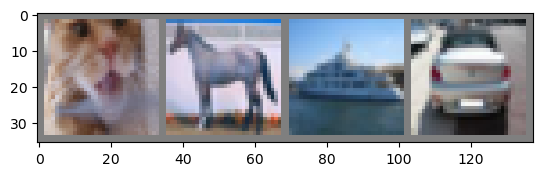

cat   horse ship  car  


In [102]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [103]:
import torch.nn as nn
import torch.nn.functional as F

# Imagen 3x32x32
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Input de imagen 3 canales, 64 filtros, kernel 3x3
        self.dropout = nn.Dropout(0.2)
        self.conv1 = nn.Conv2d(3, 64, 3)
        # MaxPooling 2x2
        self.pool = nn.MaxPool2d(2, 2)
        self.pool_padd = nn.MaxPool2d(kernel_size=2, stride=2, padding=1) # Este padding será agregado a la imagen de entrada
        # Input de imagen 64 canales, 128 filtros, kernel 3x3
        self.conv2 = nn.Conv2d(64, 128, 3)
        # Input de imagen 128 canales, 256 filtros, kernel 3x3
        self.conv3 = nn.Conv2d(128,256,3)
        self.fc1 = nn.Linear(256 * 3 * 3, 240)
        self.fc2 = nn.Linear(240, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool_padd(F.relu(self.conv2(x)))
        x = self.pool_padd(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net().to(device) 

### Momentum
 - Momentum de 0.9: Esto significa que el 90% del valor de la actualización anterior se retiene y se suma al 10% del gradiente actual para actualizar los parámetros.
#### Beneficios del momentum:
- **Aceleración**: El momentum ayuda a acelerar el descenso en la dirección correcta. Si las actualizaciones anteriores se han movido en una dirección constante, el término de momentum reforzará ese movimiento, acelerando el proceso.

- **Reducción de oscilaciones**: En regiones donde la dirección de la pendiente cambia rápidamente, como en valles o crestas, el momentum ayuda a suavizar las actualizaciones, reduciendo las oscilaciones y evitando que los parámetros se "muevan" demasiado en direcciones opuestas.

In [104]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0005, momentum=0.8)

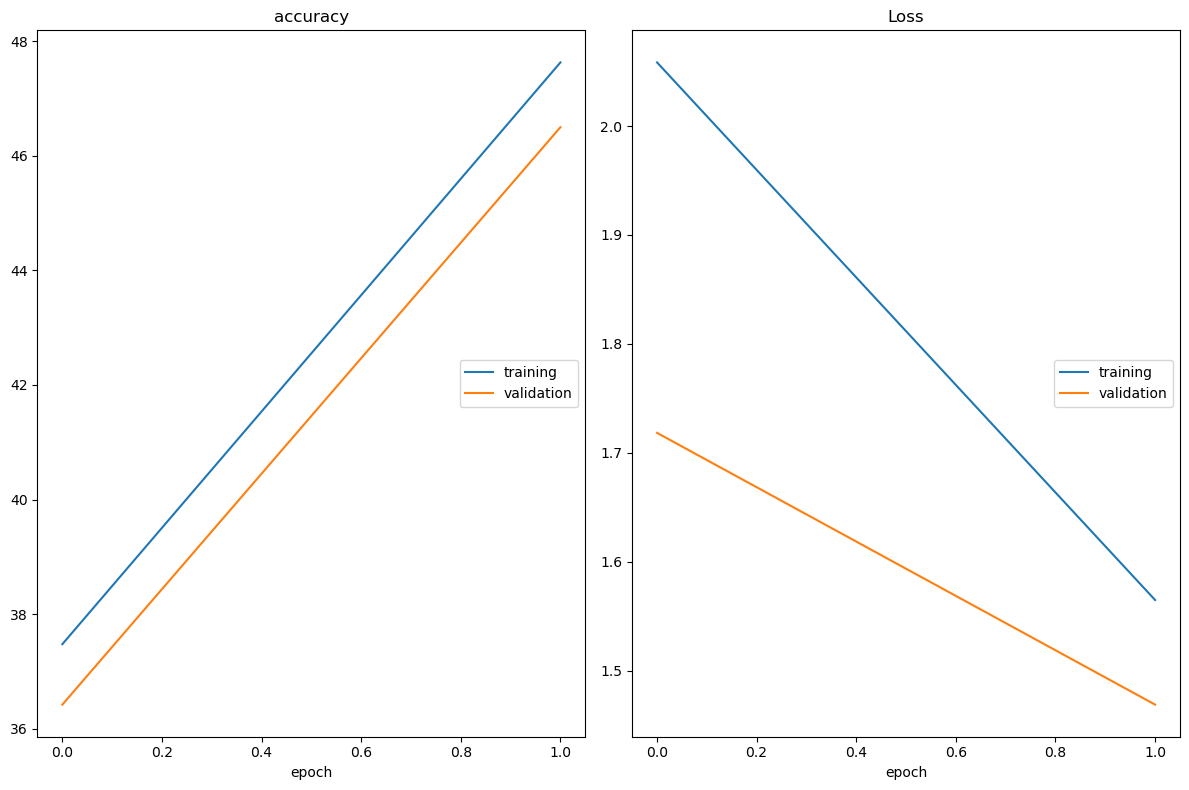

Training model...:  13%|█▎        | 2/15 [05:13<33:56, 156.64s/it]

accuracy
	training         	 (min:   37.476, max:   47.631, cur:   47.631)
	validation       	 (min:   36.420, max:   46.500, cur:   46.500)
Loss
	training         	 (min:    1.565, max:    2.058, cur:    1.565)
	validation       	 (min:    1.469, max:    1.718, cur:    1.469)
[3,  2000] loss: 1.431
[3,  4000] loss: 1.390
[3,  6000] loss: 1.366
[3,  8000] loss: 1.342
[3, 10000] loss: 1.305


In [105]:
net, loss_lst, val_loss_lst = training_model(net, train_loader, validation_loader, criterion, optimizer, NUM_EPOCHS)


In [77]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

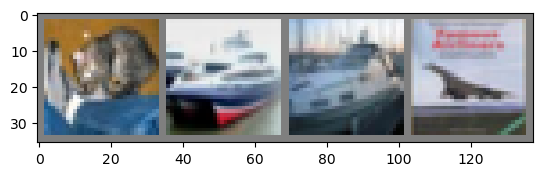

GroundTruth:  cat   ship  ship  plane


In [78]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [79]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [80]:
outputs = net(images)

In [81]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  plane


In [82]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 72 %


In [83]:
# prepare to count predictions for each class
def get_correct_and_total_pred(classes, testloader, net):
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
    return correct_pred, total_pred

correct_pred, total_pred = get_correct_and_total_pred(classes, testloader, net)

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 82.1 %
Accuracy for class: car   is 80.5 %
Accuracy for class: bird  is 62.9 %
Accuracy for class: cat   is 56.9 %
Accuracy for class: deer  is 67.4 %
Accuracy for class: dog   is 68.3 %
Accuracy for class: frog  is 84.4 %
Accuracy for class: horse is 72.7 %
Accuracy for class: ship  is 80.1 %
Accuracy for class: truck is 69.1 %
